# **BSP Project: ECG signal decomposition using Fourier analysis**

*   **Author:** Matteo Onger
*   **Date:** February 2025

**Documentation**:
*   Paper: [ECG signal decomposition using Fourier analysis](https://doi.org/10.1186/s13634-024-01171-x)
*   Dataset: ...

**Notes**:
*   ...

In [2]:
# ---- LIBRARIES ----
import importlib
import matplotlib.pyplot as plt
import numpy as np
import logging
import os

from math import ceil


# set logger
logging.basicConfig(format="%(asctime)s | %(levelname)s | %(name)s:%(funcName)s - %(message)s", level=logging.INFO, force=True)
logger = logging.getLogger(__name__)


# current runtime type, if gpu available use cupy else numpy
if os.environ["COLAB_GPU"] != "":
    GPU = True
    logger.info("GPU connected")
    logger.info("Load Cupy")
    ncp = importlib.import_module("cupy")
else:
    GPU = False
    logger.info("No accelerator connected")
    ncp = np

2025-01-18 17:22:51,638 | INFO | __main__:<cell line: 0> - No accelerator connected


In [3]:
# ---- FUNCTIONS ----
def dft_l1(x :ncp.ndarray, K :int, max_iters :int=1) -> ncp.ndarray:
    """
    """
    N = len(x)
    if (K != N) and (K > 1 + N//2):
        raise ValueError("<K> must be equal to the length of <x> or smaller/equal than half the length of <x> plus 1")

    # if gpu available, move data to the device
    isnumpy = isinstance(x, np.ndarray)
    if GPU and isnumpy:
        x = ncp.asarray(x)

    # ensure <x> is a real signal
    x = ncp.real(x)

    # matrix of fourier basis and its conjugate transpose
    fi = ncp.exp(
        ncp.array([[1j * (2 * ncp.pi * k / N) * n for k in range(K)] for n in range(N)])
    )
    tconj_fi = ncp.transpose(ncp.conj(fi))

    # fourier coefficients
    coeff = ncp.zeros(K, dtype=ncp.complex128)
    # <xm> is the reconstructed signal
    xm = x + 1

    for iter in range(max_iters):
        delta = ncp.diag(1 / ncp.abs(x - xm))

        # update fourier coefficients and reconstructed signal
        coeff = ncp.linalg.inv(tconj_fi @ delta @ fi) @ tconj_fi @ delta @ x
        xm = fi @ coeff if K == N else idft_l1(coeff, N)

        #logger.debug(f"Iteration {iter+1} -> avg_abs_loss={ncp.mean(ncp.abs((x - xm) / x))}")

    #logger.info(f"End -> avg_abs_loss={(ncp.abs((x - np.real(xm)) / x))}")
    return ncp.asnumpy(coeff) if GPU and isnumpy else coeff


def idft_l1(coeff :ncp.ndarray, N:int) -> ncp.ndarray:
    """
    """
    K = len(coeff)
    if (K != N) and (K > 1 + N//2):
        raise ValueError("the number of coefficients must be equal to <N> or smaller/equal than <N> half plus 1")

    # if gpu available, move data to the device
    isnumpy = isinstance(coeff, np.ndarray)
    if GPU and isnumpy:
        coeff = ncp.asarray(coeff)

    # matrix of fourier basis
    fi = ncp.exp(
        ncp.array([[1j * (2 * ncp.pi * k / N) * n for k in range(K)] for n in range(N)])
    )

    # <xm> is the reconstructed signal
    xm = ncp.zeros(N, dtype=ncp.complex128)

    if K == N:
        xm = fi @ coeff
    else:
        # conjugate fourier coefficients and basis
        conj_coeff = ncp.conj(coeff)
        conj_fi = ncp.conj(fi)

        conj_coeff[0] = 0
        if (N % 2 == 0) and (K == 1 + N//2):
            conj_coeff[-1] = 0

        xm = (fi @ coeff) + (conj_fi @ conj_coeff)
    return ncp.asnumpy(xm) if GPU and isnumpy else xm

## An example:

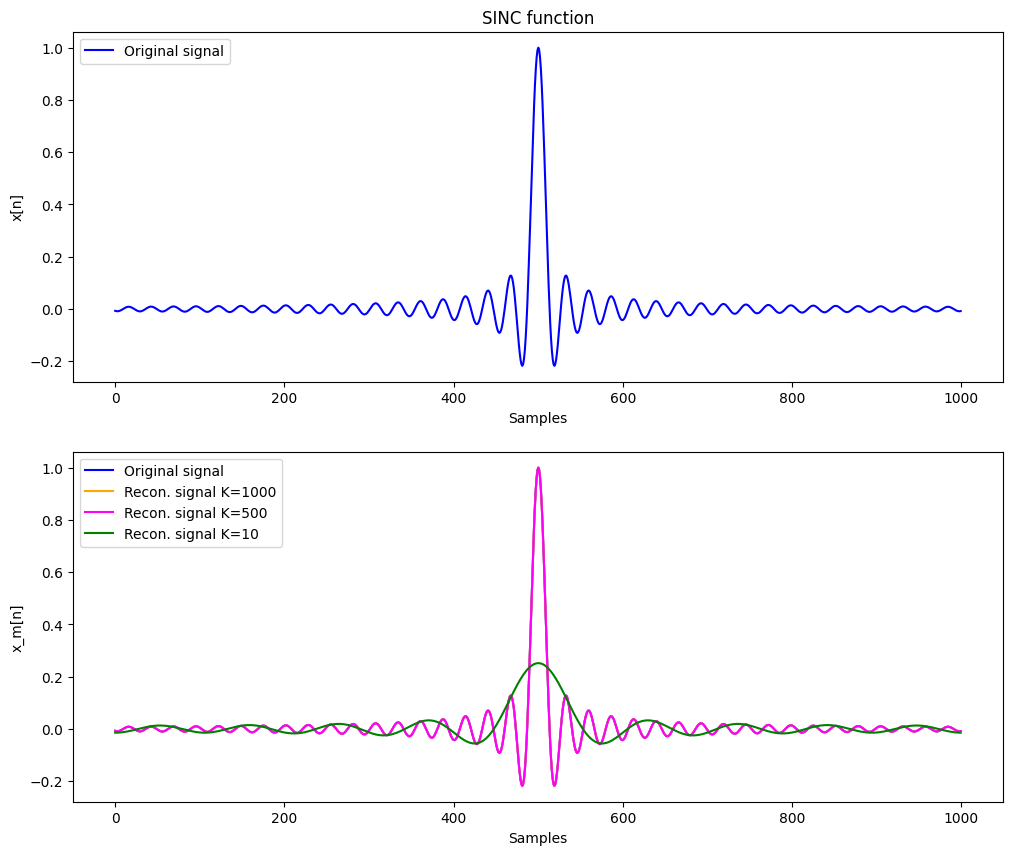

In [18]:
# frequency
f = 12
# number of samples
N = 1000

# original signal
n = np.arange(N)
x = np.sinc(2 * np.pi * f * np.linspace(-0.5, 0.5, N, endpoint=False))

# compute dft and reconstruct the signal
c1 = dft_l1(x, K=1000)
c2 = dft_l1(x, K=500)
c3 = dft_l1(x, K=10)

xm1 = idft_l1(c1, N=N)
xm2 = idft_l1(c2, N=N)
xm3 = idft_l1(c3, N=N)

# plot the results
plt.figure(1, figsize=(12, 10))

plt.subplot(211)
plt.title("SINC function")
plt.plot(n, x, c="blue", label="Original signal")
plt.xlabel("Samples")
plt.ylabel("x[n]")
plt.legend(loc="upper left")

plt.subplot(212)
plt.plot(n, x, c="blue", label="Original signal")
plt.plot(n, np.real(xm1), c="orange", label="Recon. signal K=1000")
plt.plot(n, np.real(xm2), c="magenta", label="Recon. signal K=500")
plt.plot(n, np.real(xm3), c="green", label="Recon. signal K=10")
plt.xlabel("Samples")
plt.ylabel("x_m[n]")
plt.legend(loc="upper left")

plt.show()

## ...